<a href="https://colab.research.google.com/github/JoelPasapera/AI-Strategies-in-python-google-colab-/blob/main/Model%201%5CRed_neuronal_trading_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from google.colab import files

In [4]:
### --- 1. CONFIGURACIÓN Y CARGA DE DATOS ---

# Carga el archivo CSV desde tu computadora
print("Por favor, sube tu archivo CSV (ej: gbpusd_1h.csv)")
uploaded = files.upload()

Por favor, sube tu archivo CSV (ej: gbpusd_1h.csv)


Saving GBPUSD_16385_minutes.csv to GBPUSD_16385_minutes.csv


Datos de entrenamiento: 9299 secuencias
Datos de prueba: 2325 secuencias


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando entrenamiento...
Epoch 1/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - loss: 0.0146 - val_loss: 3.0257e-04
Epoch 2/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - loss: 0.0013 - val_loss: 2.2119e-04
Epoch 3/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - loss: 9.1174e-04 - val_loss: 3.8988e-04
Epoch 4/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - loss: 7.5748e-04 - val_loss: 1.7131e-04
Epoch 5/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - loss: 5.8254e-04 - val_loss: 3.8405e-04
Epoch 6/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - loss: 5.0898e-04 - val_loss: 1.9258e-04
Epoch 7/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - loss: 4.7548e-04 - val_loss: 2.7313e-04
Epoch 8/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - loss: 4.4910e-04 - val_loss: 2.3517e-04
Epoch 9/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - loss: 4.5179e-04 - val_loss: 3.2831e-04
Epoch 10/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - loss: 4.3533e-04 - val_loss: 1.2832e-04
Epoch 11/25
291/291

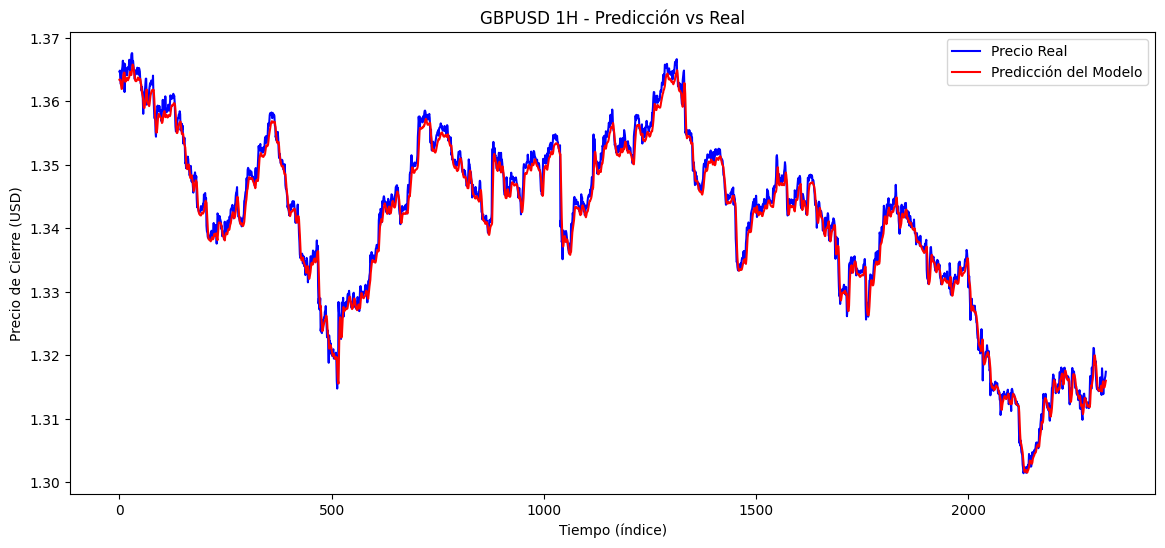

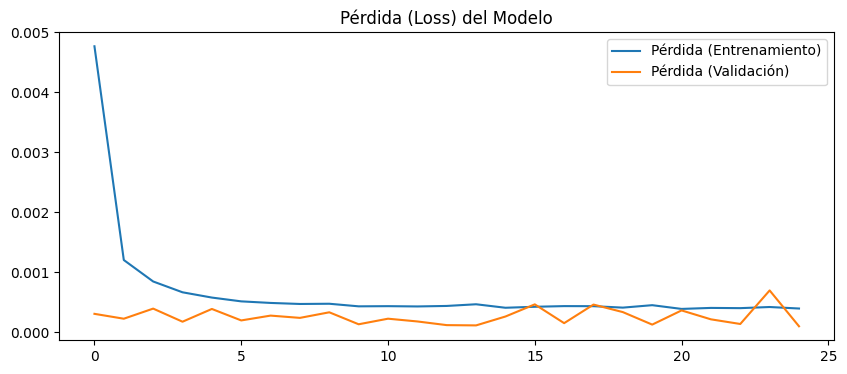

In [6]:
# Obtén el nombre del archivo que acabas de subir
# Asumimos que solo subiste un archivo
file_name = list(uploaded.keys())[0]

# Carga los datos en un DataFrame de Pandas
df = pd.read_csv(file_name, encoding='utf-16')

# --- 2. PREPARACIÓN DE DATOS ---

# Convertir la columna 'date' a formato datetime
df['date'] = pd.to_datetime(df['date'])

# ¡MUY IMPORTANTE! Ordenar los datos cronológicamente (de más antiguo a más nuevo)
# Tus datos de ejemplo están al revés (de más nuevo a más antiguo)
df = df.sort_values(by='date', ascending=True)

# Nos enfocaremos en predecir el precio de 'close'
# Convertimos el 'close' en un array de numpy
data = df['close'].values.reshape(-1, 1)

# Normalizar los datos: Las RNNs funcionan mejor con datos escalados (entre 0 y 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# --- Creación de Secuencias (Ventana de tiempo) ---
# El modelo mirará 'look_back' datos pasados para predecir el siguiente.
# 'look_back' es la "memoria" del modelo. 60 horas (2.5 días) es un buen punto de partida.
LOOK_BACK = 60

X = []
y = []

for i in range(LOOK_BACK, len(scaled_data)):
    # X: Contiene los 60 precios de 'close' anteriores
    X.append(scaled_data[i-LOOK_BACK:i, 0])
    # y: Contiene el precio de 'close' siguiente (el que queremos predecir)
    y.append(scaled_data[i, 0])

# Convertir a arrays de numpy
X, y = np.array(X), np.array(y)

# Reformatear X para la LSTM: [muestras, pasos_de_tiempo, características]
# La LSTM espera una entrada 3D.
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# --- División de datos: 80% Entrenamiento, 20% Prueba ---
# En series temporales, NO mezclamos los datos. El orden importa.
split_index = int(len(X) * 0.8)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Datos de entrenamiento: {len(X_train)} secuencias")
print(f"Datos de prueba: {len(X_test)} secuencias")


# --- 3. CONSTRUCCIÓN DEL MODELO LSTM ---

# Usamos 'Sequential' para apilar capas
model = Sequential()

# Capa 1: LSTM
# units=50: 50 neuronas en la capa
# return_sequences=True: necesario porque apilaremos otra capa LSTM
# input_shape: (60 pasos de tiempo, 1 característica)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2)) # Dropout para prevenir sobreajuste (overfitting)

# Capa 2: LSTM
model.add(LSTM(units=50, return_sequences=False)) # False porque es la última capa LSTM
model.add(Dropout(0.2))

# Capa 3: Densa (Capa oculta regular)
model.add(Dense(units=25))

# Capa 4: Densa (Capa de salida)
model.add(Dense(units=1)) # '1' porque queremos predecir 1 solo valor (el próximo 'close')

# Compilar el modelo
# 'adam' es un optimizador eficiente
# 'mean_squared_error' es la función de pérdida estándar para regresión (predicción de números)
model.compile(optimizer='adam', loss='mean_squared_error')

# Muestra un resumen de la arquitectura del modelo
model.summary()


# --- 4. ENTRENAMIENTO DEL MODELO ---

print("\nIniciando entrenamiento...")
# Entrenamos el modelo
history = model.fit(
    X_train,
    y_train,
    epochs=25,       # 25 pasadas completas sobre los datos
    batch_size=32,   # Procesar en lotes de 32
    validation_data=(X_test, y_test), # Usar los datos de prueba para validar
    verbose=1
)
print("Entrenamiento completado.")


# --- 5. EVALUACIÓN Y VISUALIZACIÓN ---

print("Generando predicciones...")
# Hacer predicciones con los datos de prueba
predictions = model.predict(X_test)

# **Importante**: Invertir la normalización
# Tenemos que revertir la escala para que las predicciones
# y los valores reales estén en la escala original de precios (ej. 1.317440)
predictions = scaler.inverse_transform(predictions)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Graficar los resultados ---
plt.figure(figsize=(14, 6))
plt.title('GBPUSD 1H - Predicción vs Real')
plt.ylabel('Precio de Cierre (USD)')
plt.xlabel('Tiempo (índice)')
plt.plot(y_test_real, color='blue', label='Precio Real')
plt.plot(predictions, color='red', label='Predicción del Modelo')
plt.legend()
plt.show()

# (Opcional) Graficar la pérdida del modelo durante el entrenamiento
plt.figure(figsize=(10, 4))
plt.title('Pérdida (Loss) del Modelo')
plt.plot(history.history['loss'], label='Pérdida (Entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (Validación)')
plt.legend()
plt.show()